# A brief analysis of Airbnb's semi-structured data with PyMongo.

This practice is a brief analysis of a high volume of semi-structured data. I loaded a large set of publicly available real data into MongoDB and performed a quick analysis process using Python's map and reduce techniques. 

The data is available from the data source link:
https://www.mongodb.com/docs/atlas/sample-data/sample-airbnb/#std-label-sample-airbnb

In [1]:
#Let's import the required packages
import pandas as pd
import altair as alt
from pymongo import MongoClient
from bson.code import Code
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
#Let's connect in my local MongoDB. The Airbnb data were previously imported to MongoDB.
client = MongoClient("mongodb://127.0.0.1:27017")
print("Connection Successful")
client.close()

Connection Successful


In [3]:
#Let's set the database and the collection to work with.
dsadb = client.dsadb
airbnbcollection = dsadb.airbnb

In [4]:
#One can retrieve the semi-structured data into a structured data like pandas dataframe.
datapoints = list(airbnbcollection.find({}))
df = pd.json_normalize(datapoints)
df.head()

,_id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,review_scores.review_scores_accuracy,review_scores.review_scores_cleanliness,review_scores.review_scores_checkin,review_scores.review_scores_communication,review_scores.review_scores_location,review_scores.review_scores_value,review_scores.review_scores_rating,weekly_price,monthly_price,reviews_per_month
0,10006546,https://www.airbnb.com/rooms/10006546,Ribeira Charming Duplex,Fantastic duplex apartment with three bedrooms...,Privileged views of the Douro River and Ribeir...,Fantastic duplex apartment with three bedrooms...,"In the neighborhood of the river, you can find...",Lose yourself in the narrow streets and stairc...,Transport: • Metro station and S. Bento railwa...,We are always available to help guests. The ho...,...,9.0,9.0,10.0,10.0,10.0,9.0,89.0,NaN,NaN,NaN
1,10009999,https://www.airbnb.com/rooms/10009999,Horto flat with small garden,One bedroom + sofa-bed in quiet and bucolic ne...,Lovely one bedroom + sofa-bed in the living ro...,One bedroom + sofa-bed in quiet and bucolic ne...,This charming ground floor flat is located in ...,"There´s a table in the living room now, that d...","Easy access to transport (bus, taxi, car) and ...",,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492.00,4849.00,NaN
2,1001265,https://www.airbnb.com/rooms/1001265,Ocean View Waikiki Marina w/prkg,A short distance from Honolulu's billion dolla...,Great studio located on Ala Moana across the s...,A short distance from Honolulu's billion dolla...,You can breath ocean as well as aloha.,,Honolulu does have a very good air conditioned...,"Pool, hot tub and tennis",...,9.0,8.0,9.0,9.0,10.0,9.0,84.0,650.00,2150.00,NaN
3,10021707,https://www.airbnb.com/rooms/10021707,Private Room in Bushwick,Here exists a very cozy room for rent in a sha...,,Here exists a very cozy room for rent in a sha...,,,,,...,10.0,10.0,10.0,10.0,8.0,8.0,100.0,NaN,NaN,NaN
4,10030955,https://www.airbnb.com/rooms/10030955,Apt Linda Vista Lagoa - Rio,Quarto com vista para a Lagoa Rodrigo de Freit...,,Quarto com vista para a Lagoa Rodrigo de Freit...,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#One can count how many documents are in the dataset.
airbnbcollection.count_documents({})

5555

In [6]:
# One can create a dataframe and check how many rows and columns.
df.shape

(5555, 77)

In [7]:
#One can filter specific documents and create a dataframe with them.
pd.json_normalize(airbnbcollection.find({"property_type" : "House"},{"property_type" : True, "cancellation_policy" : True, "_id": False}))

,property_type,cancellation_policy
0,House,moderate
1,House,flexible
2,House,strict_14_with_grace_period
3,House,moderate
4,House,strict_14_with_grace_period
...,...,...
601,House,flexible
602,House,strict_14_with_grace_period
603,House,moderate
604,House,flexible


In [8]:
#One can order these documents
pd.json_normalize(airbnbcollection.find({"property_type" : "House"},
                                        {"property_type" : True, "cancellation_policy" : True, "_id": False}).\
                                        sort("cancellation_policy", -1))

,property_type,cancellation_policy
0,House,super_strict_60
1,House,super_strict_60
2,House,super_strict_60
3,House,super_strict_60
4,House,super_strict_60
...,...,...
601,House,flexible
602,House,flexible
603,House,flexible
604,House,flexible


In [9]:
#One can perform aggregations calculating the data count, sum, or average.
aggsample=pd.json_normalize(airbnbcollection.aggregate(
    [{
    "$group" : 
        {"_id":"$property_type",
         "count": {"$sum" : 1},
         "average":{"$avg":"$number_of_reviews"}}}], 
        allowDiskUse = True)).rename(columns={"_id": "Property_type", "count": "Count", "average": "Average"})
aggsample

,Property_type,Count,Average
0,Other,18,16.111111
1,Barn,1,19.000000
2,Heritage hotel (India),1,0.000000
3,Loft,142,40.000000
4,Serviced apartment,185,12.843243
5,Tiny house,7,18.428571
6,Bungalow,14,37.285714
7,Train,1,89.000000
8,Casa particular (Cuba),9,0.888889
9,Boutique hotel,53,17.603774


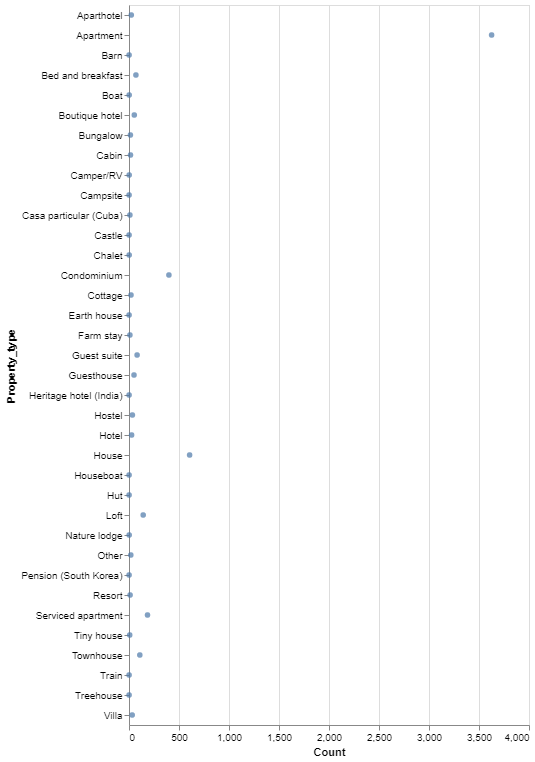

In [10]:
#Let's do some charts with the aggregated data.
alt.Chart(aggsample).mark_circle().encode(
    x='Count:Q',
    y='Property_type:N',)

One can perform optmized calculations with map and reduce. Let's do it!

In [11]:
map = Code("function(){emit(Math.floor(this.number_of_reviews), 1)}")

In [12]:
reduce = Code("function(id, counts){return Array.sum(counts)}")

In [13]:
result = pd.json_normalize(airbnbcollection.map_reduce(map, reduce, "myresults").find()).\
            rename(columns={"_id": "Number_of_reviews", "value": "Count"}).\
            sort_values('Count', ascending=False).head(10)
result

,Number_of_reviews,Count
241,0.0,1388.0
1,1.0,511.0
228,2.0,329.0
134,3.0,247.0
164,4.0,187.0
107,6.0,139.0
7,5.0,128.0
135,7.0,107.0
99,8.0,88.0
41,12.0,71.0


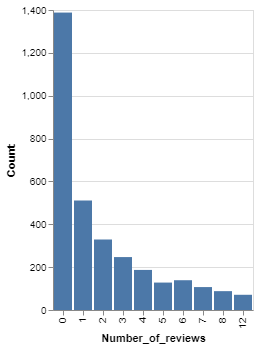

In [14]:
#Let's make some graphics with the calculated data.
alt.Chart(result).mark_bar().encode(
    x='Number_of_reviews:N',
    y='Count:Q',)

Let's count the number of Airbnb properties by how many bedrooms.

In [15]:
map = Code("function(){emit(Math.floor(this.bedrooms), 1)}")

In [16]:
reduce = Code("function(id, counts){return Array.sum(counts)}")

In [17]:
result = pd.json_normalize(airbnbcollection.map_reduce(map, reduce, "myresults").find()).\
            rename(columns={"_id": "Number_of_bedrooms", "value": "Count"}).dropna().\
            sort_values('Count', ascending=False)
result

,Number_of_bedrooms,Count
5,1.0,3308.0
9,2.0,1090.0
11,0.0,496.0
8,3.0,427.0
4,4.0,161.0
10,5.0,36.0
0,6.0,16.0
12,7.0,7.0
3,8.0,3.0
2,10.0,2.0


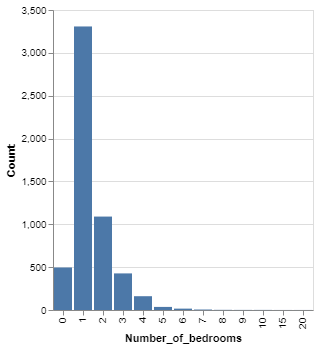

In [18]:
#Let's make a simple graphic.
alt.Chart(result).mark_bar().encode(
    x='Number_of_bedrooms:N',
    y='Count:Q',)